In [111]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl
changing to root directory
at directory: /Users/wilka/git


In [113]:
import jax
from projects.humansf import visualizer

from projects.socialsf.level import Level
from projects.socialsf.maze import Maze
from projects.socialsf.renderer import MazeRenderer


# Complicated goals

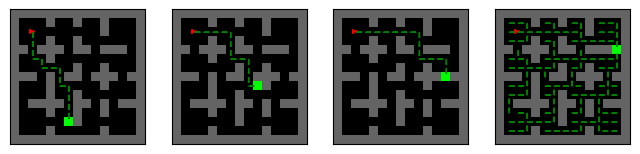

In [179]:
seed=3
rng = jax.random.PRNGKey(seed)


def plot_level(level, setting='level', **kwargs):
    env = Maze(max_height=13, max_width=13, agent_view_size=1, normalize_obs=True)
    env_params = env.default_params
    env_renderer = MazeRenderer(env, tile_size=8)
    level = Level.from_str(level, assert_agent_goal=False)

    obs, env_state = env.reset_to_level(rng, level, env_params)
    
    if setting == 'level':
        visualizer.display_image(env_renderer.render_level(env_state, env_params), **kwargs)
    elif setting == 'flow':
        actions = find_optimal_actions(env_state.maze_map, floor_array, wall_array, goal_array)
        image = env_renderer.render_state(env_state, env_params)
        place_arrows_on_image(image, actions, env_state, offset=8, **kwargs)
    elif setting == 'path':
        actions = find_optimal_actions(env_state.maze_map, floor_array, wall_array, goal_array)
        image = env_renderer.render_state(env_state, env_params)
        show_path_to_goal(image, tuple(int(i) for i in env_state.agent_pos), actions, env_state, offset=8, **kwargs)
    elif setting == 'both':
        fig, axs = plt.subplots(1, 2, figsize=(8, 8))
        env_renderer = MazeRenderer(env, tile_size=8)
        image = env_renderer.render_state(env_state, env_params)
        actions = find_optimal_actions(env_state.maze_map, floor_array, wall_array, goal_array)
        place_arrows_on_image(image, actions, env_state, ax=axs[0], offset=8)
        show_path_to_goal(image, tuple(int(i) for i in env_state.agent_pos), actions, env_state, ax=axs[1], offset=8)
    else:
        raise RuntimeError



nplots = 4
width = 2
fig, axs = plt.subplots(1, nplots, figsize=(width*nplots, width))

axss = iter(axs.ravel())

level = Maze1 = """
...#..#..#...
.>.......#...
...#..#......
#.###.##.###.
...#.........
......#..#...
##.#.##.###.#
...#.....#...
...#..#......
.####.##.#.##
...#..#..#...
.....G#......
...#.....#...
""".strip()

plot_level(Maze1, setting='path', ax=next(axss))


level = Maze1 = """
...#..#..#...
.>.......#...
...#..#......
#.###.##.###.
...#.........
......#..#...
##.#.##.###.#
...#....G#...
...#..#......
.####.##.#.##
...#..#..#...
......#......
...#.....#...
""".strip()

plot_level(Maze1, setting='path', ax=next(axss))

level = """
...#..#..#...
.>.......#...
...#..#......
#.###.##.###.
...#.........
......#..#...
##.#.##.###G#
...#.....#...
...#..#......
.####.##.#.##
...#..#..#...
......#......
...#.....#...
""".strip()

plot_level(level, setting='path', ax=next(axss))

level = """
...#..#..#...
.>.......#...
...#..#......
#.###.##.###G
...#.........
......#..#...
##.#.##.###.#
...#.....#...
...#..#......
.####.##.#.##
...#..#..#...
......#......
...#.....#...
""".strip()

plot_level(level, setting='flow', ax=next(axss))

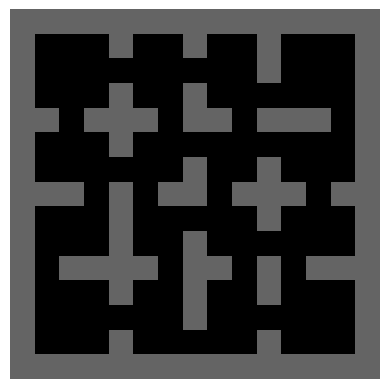

In [178]:
level = """
...#..#..#...
.........#...
...#..#......
#.###.##.###.
...#.........
......#..#...
##.#.##.###.#
...#.....#...
...#..#......
.####.##.#.##
...#..#..#...
......#......
...#.....#...
""".strip()

plot_level(level)

okay, so what do I want to do?

my goal is to show that if a goal is "hard", i.e. the plan for it is not obvious, then you will resort to using a predictive representation *that is sub-optimal*.

what does it mean to re-use a predictive representation?
(a) in terms of what's the path to get to a goal? So, you see a goal, and you have to predict /how/ somebody will get there. This is like a goal of GPI.
(b) the other way to re-use a predictive representation is to use it to infer what goal someone is pursuing. so basically, if a planning a path to a goal is hard. okay, so you have multiple goals and all require planning. if you're in that condition, what you'll do is re-use what you've seen before. this is __completely trivial__ from the same starting position that you saw before. so it needs to be that this is a new starting position.

okay, so what makes sense is that you've seen a bunch of paths towards the goal from across the map. same goal. and then you see someone starting on a path you know. and you can use that to predict the goal __very__ quickly.

and if two goals have overlap, only once they no longer overlap do you know. and a measurement of this discrepancy comes from the literal state occupancy measure. and the hypothesis, is that we do an expectation is over all sources of randomness, with a world model that is structured and includes a policy for other agents. so we compute the occupancy measure for the other agent using the exact same math. okay, so I need to examples.

What conditions should the examples fulfill?
1. seperate goals
2. have experienced paths to that goal
3. given a new path,

# Simple goals

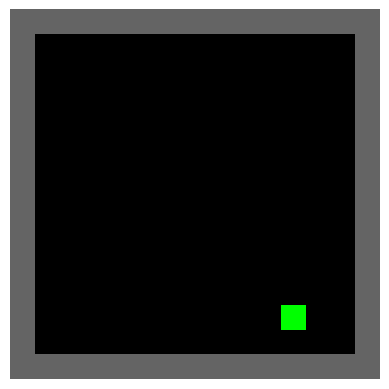

In [183]:
seed=3
rng = jax.random.PRNGKey(seed)

level = SimpleMaze1 = """
.............
.............
.............
.............
.............
.............
.............
.............
.............
.............
.............
.............
.............
""".strip()

plot_level(level)